# Algorytm Grovera

In [2]:
#importujemy package cirq
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

#importujemy numpy
import numpy as np
import random

Rozważmy ciągi bitów o długiści n oraz element $x' \in {0,1}^n$ - jest to szukany ciąg znaków. Potrzebujemy funkcję $f: {0,1}^n \rightarrow {0,1}$, która zdefiniowana jest w następujący sposób:
$f(x) = 1$ gdy $x=x'$, $f(x)=0$ gdy $x \neq x'$

In [3]:
#Liczba kubitów
nqubits = 2

#Deklarujemy rejestr kubitów i kubit posiłkowy (ancillary)
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

In [4]:
def make_oracle(qubits, ancilla, xprime):
    # Odwraca szukany stan
    # Negacja bitów zerowych
    yield (cirq.X(q) for (q,bit) in zip(qubits,xprime) if not bit)
    # Bramka TOFFOLI
    yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))
    # Negacja bitów zerowych
    yield (cirq.X(q) for (q,bit) in zip(qubits,xprime) if not bit)
    

In [5]:
def grover_iteration(qubits, ancilla, oracle):
    circuit = cirq.Circuit()
    
    # Tworzymy jednakowe superpozycje wejściowych kubitów
    circuit.append(cirq.H.on_each(*qubits))
    
    # Ustawiamy kubit wyjściowy w stanie |->
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
    
    # Operator "wyroczni"
    circuit.append(oracle)
    
    # Konstruujemy operator Grovera dla nqubits = 2
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))
    
    # Dokonujemy pomiaru kubitów
    circuit.append(cirq.measure(*qubits, key="result"))
    
    return circuit
    

In [28]:
# Losujemy x'
xprime = [random.randint(0,1) for _ in range(nqubits)]
print(f"Wylosowany ciąg: {xprime}")

Wylosowany ciąg: [0, 0]


In [30]:
# Tworzymy układ do algorytmu Grovera

# Generujemy operator "wyroczni"
oracle = make_oracle(qubits, ancilla, xprime)

# Układ
circuit = grover_iteration(qubits, ancilla, oracle)
print("Układ do algorytmu Grovera:")
print(circuit)

Układ do algorytmu Grovera:
0: ─────────H───X───@───X───H───X───────@───X───H───────M('result')───
                    │                   │               │
1: ─────────H───X───@───X───H───X───H───X───H───X───H───M─────────────
                    │
Ancilla: ───X───H───X─────────────────────────────────────────────────


In [31]:
# Symylacja układu

#Funkcja pomocnicza
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

# Symulacja
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)

# Wyswietl rezultat
frequencies = result.histogram(key = "result", fold_func = bitstring)
print("Zebrane wyniki:\n{}".format(frequencies))

#Sprawdzenie, czy znaleziono prawidłową wartość
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nNajczestszy rezultat: {}".format(most_common_bitstring))
print("Czy znaleziono? {}".format(most_common_bitstring == bitstring(xprime)))

Zebrane wyniki:
Counter({'00': 10})

Najczestszy rezultat: 00
Czy znaleziono? True


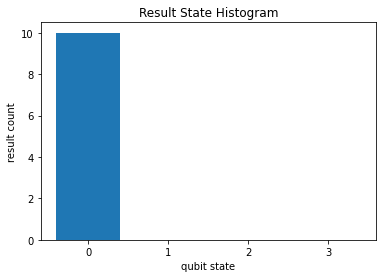

In [32]:
import matplotlib.pyplot as plt

cirq.plot_state_histogram(result, plt.subplot())
plt.show()